In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/PhasingFamilies/parameter_estimation/compare_rates.py'>

In [2]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# Population distributions

In [18]:
ihart_samples = compare_rates.pull_samples('../split_gen_ihart', chroms)
spark_exome_samples = compare_rates.pull_samples('../split_gen_spark_exome', chroms)
spark_samples = compare_rates.pull_samples('../split_gen_spark', chroms)

ihart_LCR_samples = compare_rates.pull_samples('../split_gen_ihart_LCR', chroms)
ihart_HCR_samples = compare_rates.pull_samples('../split_gen_ihart_HCR', chroms)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


In [6]:
ihart_baseline_counts = compare_rates.pull_baseline_counts(ihart_samples, '../split_gen_ihart', chroms, gens, obss)
spark_exome_baseline_counts = compare_rates.pull_baseline_counts(spark_exome_samples, '../split_gen_spark_exome', chroms, gens, obss)
spark_baseline_counts = compare_rates.pull_baseline_counts(spark_samples, '../split_gen_spark', chroms, gens, obss)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [19]:
ihart_LCR_baseline_counts = compare_rates.pull_baseline_counts(ihart_LCR_samples, '../split_gen_ihart_LCR', chroms, gens, obss)
ihart_HCR_baseline_counts = compare_rates.pull_baseline_counts(ihart_HCR_samples, '../split_gen_ihart_HCR', chroms, gens, obss)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [22]:
ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, 'ihart_ind_pass_nodel_params.json', chroms, gens, obss)
spark_exome_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'spark_exome_ind_pass_nodel_params.json', chroms, gens, obss)
spark_error_rates = compare_rates.pull_error_rates(spark_samples, 'spark_ind_pass_nodel_params.json', chroms, gens, obss)

ihart_LCR_error_rates = compare_rates.pull_error_rates(ihart_LCR_samples, 'ihart_LCR_ind_pass_nodel_params.json', chroms, gens, obss)
ihart_HCR_error_rates = compare_rates.pull_error_rates(ihart_HCR_samples, 'ihart_HCR_ind_pass_nodel_params.json', chroms, gens, obss)


In [23]:
ihart_error_counts = compare_rates.estimate_error_counts(ihart_baseline_counts, ihart_error_rates, chroms, gens, obss)
spark_exome_error_counts = compare_rates.estimate_error_counts(spark_exome_baseline_counts, spark_exome_error_rates, chroms, gens, obss)
spark_error_counts = compare_rates.estimate_error_counts(spark_baseline_counts, spark_error_rates, chroms, gens, obss)


ihart_LCR_error_counts = compare_rates.estimate_error_counts(ihart_LCR_baseline_counts, ihart_LCR_error_rates, chroms, gens, obss)
ihart_HCR_error_counts = compare_rates.estimate_error_counts(ihart_HCR_baseline_counts, ihart_HCR_error_rates, chroms, gens, obss)


In [25]:
def plot_data(error_rates, error_counts, samples, title, filename):
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(title, fontsize=18)

    #prop_cycle = plt.rcParams['axes.prop_cycle']
    #colors = prop_cycle.by_key()['color']
    #colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
    colors = ['#4db6ac', '#ef6c00', '#695d46', '#009668', '#ce93d8', '#b3a77d', '#cedd38']

    errors_of_interest = [('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                                ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                                #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                               ]
    for i, (g, o) in enumerate(errors_of_interest):
        plt.subplot(len(errors_of_interest), 2, 2*i+1)
        plt.hist(-np.clip(error_rates[samples.is_child, gens.index(g), obss.index(o)], 1, 7), 
                 bins=np.arange(-7, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), color=colors[i], density=True)

        plt.yticks([], [])
        if i == len(errors_of_interest)-1:
            plt.xlabel('error rate', fontsize=18)
            plt.xticks(np.arange(-7, 0), ['$10^{%d}$' % d for d in np.arange(-7, 0)], fontsize=15)
        else:
            plt.xticks([], [])

        plt.subplot(len(errors_of_interest), 2, 2*i+2)
        plt.hist(np.clip(np.log10(error_counts[samples.is_child, gens.index(g), obss.index(o)]), 0, 5), 
                 bins=np.arange(0, 5.2, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), color=colors[i], density=True)

        plt.yticks([], [])
        plt.ylabel(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=15)

        if i == len(errors_of_interest)-1:
            plt.xlabel('number of errors', fontsize=18)
            plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)], fontsize=15)
        else:
            plt.xticks([], [])

    plt.subplots_adjust(hspace=0.0, wspace=0.23)


    #plt.tight_layout()
    plt.savefig(filename)
    plt.show()

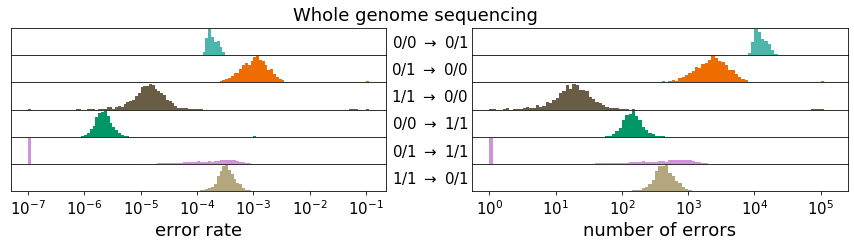

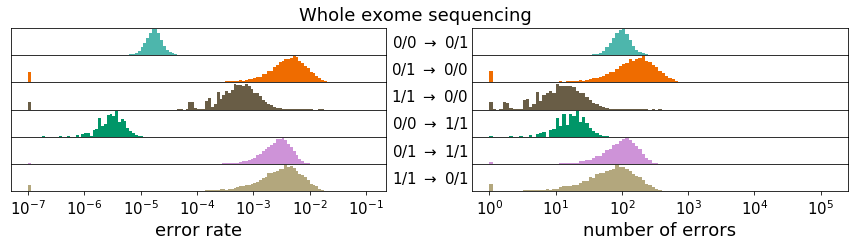

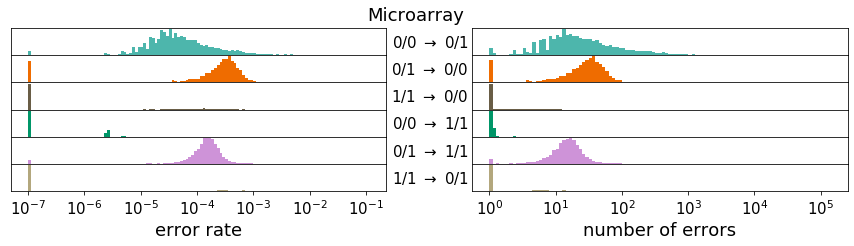

In [26]:
plot_data(ihart_error_rates, ihart_error_counts, ihart_samples, 'Whole genome sequencing', '../plots/wgs_error_rate.png')
plot_data(spark_exome_error_rates, spark_exome_error_counts, spark_exome_samples, 'Whole exome sequencing', '../plots/wes_error_rate.png')
plot_data(spark_error_rates, spark_error_counts, spark_samples, 'Microarray', '../plots/microarray_error_rate.png')

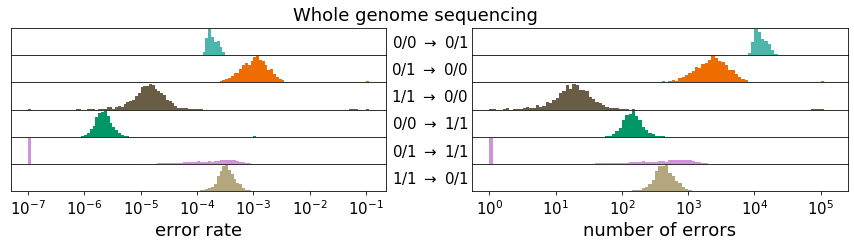

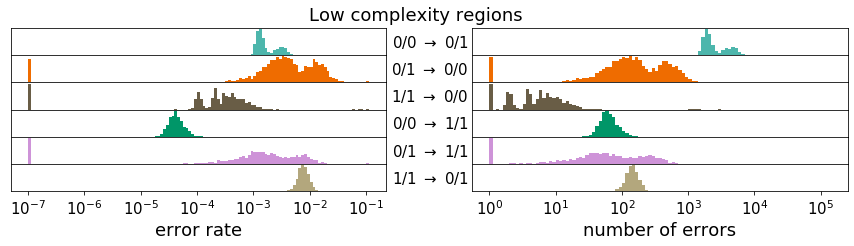

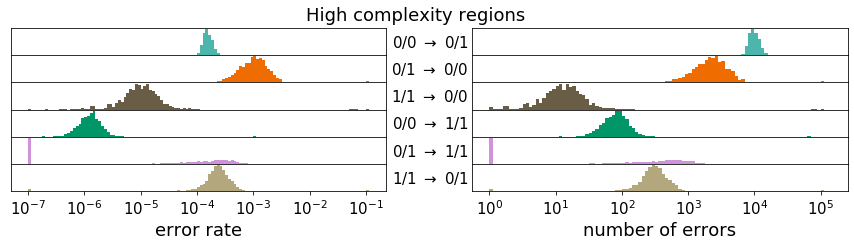

In [27]:
plot_data(ihart_error_rates, ihart_error_counts, ihart_samples, 'Whole genome sequencing', '../plots/wgs_error_rate.png')
plot_data(ihart_LCR_error_rates, ihart_LCR_error_counts, ihart_LCR_samples, 'Low complexity regions', '../plots/lcr_error_rate.png')
plot_data(ihart_HCR_error_rates, ihart_HCR_error_counts, ihart_HCR_samples, 'High complexity regions', '../plots/hcr_error_rate.png')


# Compare M/F

In [89]:
sample_id_to_sex = dict()
with open('../data/v34.vcf.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        sample_id_to_sex[pieces[1]] = pieces[4]
        
with open('../data/spark_jae_adj.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        sample_id_to_sex[pieces[1]] = pieces[4]

In [90]:
is_male = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='1' for x in ihart_samples.sample_ids])
is_female = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='2' for x in ihart_samples.sample_ids])

for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    
    x = ihart_error_rates[ihart_samples.is_child & is_male, gens.index(g), obss.index(o)]
    y = ihart_error_rates[ihart_samples.is_child & is_female, gens.index(g), obss.index(o)]
    test = scipy.stats.mannwhitneyu(x[~np.isnan(x)], y[~np.isnan(y)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue, np.nanmedian(x), np.nanmedian(y), 
          np.nanmedian(ihart_error_counts[ihart_samples.is_child & is_male, gens.index(g), obss.index(o)])-np.nanmedian(ihart_error_counts[ihart_samples.is_child & is_female, gens.index(g), obss.index(o)]),
          sep='\t')


*	0/0	0/1	3.2375060225521575e-15	3.7468274704000444	3.69621522824451	-1430.9192049885205
*	0/1	0/0	0.001091000617628273	2.9777658363339676	2.94305150761462	-168.2941384987289
	1/1	0/0	0.19288036954517057	4.84417245468366	4.842033230559898	-0.06525086659485879
	0/0	1/1	0.06337136398548385	5.659655485347386	5.651203743310447	-3.0083416604465754
*	0/1	1/1	0.00013394264827113226	3.95722240153341	3.805747535623142	-108.05074197417309
*	1/1	0/1	2.0493694230537066e-09	3.494746085660797	3.45024842947714	-47.65675877952589
*	0/0	./.	4.2411487961884853e-10	3.5103803574644035	3.4694559008785295	-1985.715345125438
*	0/1	./.	9.990969799591666e-10	3.5472760028090105	3.46843245944817	-113.38203737699826
*	1/1	./.	0.0002818375156054798	3.466647705501872	3.434068585368311	-34.490807641017454


In [91]:
is_male = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='1' for x in spark_exome_samples.sample_ids])
is_female = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='2' for x in spark_exome_samples.sample_ids])

for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    
    x = spark_exome_error_rates[spark_exome_samples.is_child & is_male, gens.index(g), obss.index(o)]
    y = spark_exome_error_rates[spark_exome_samples.is_child & is_female, gens.index(g), obss.index(o)]
    test = scipy.stats.mannwhitneyu(x[~np.isnan(x)], y[~np.isnan(y)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue, np.nanmedian(x), np.nanmedian(y), 
          np.nanmedian(spark_exome_error_counts[spark_exome_samples.is_child & is_male, gens.index(g), obss.index(o)])-np.nanmedian(spark_exome_error_counts[spark_exome_samples.is_child & is_female, gens.index(g), obss.index(o)]),
          sep='\t')


	0/0	0/1	0.13219207063453087	4.759841602228464	4.762412640793491	0.5925337346774739
*	0/1	0/0	0.0008233904049235256	2.3882372371139517	2.3613293421520023	-8.702987974416828
	1/1	0/0	0.11646426434625795	3.2536182374919975	3.249798968861161	-0.10478446990403611
*	0/0	1/1	2.2566547051211012e-07	5.490585106028254	5.515510907811939	1.00968618258144
*	0/1	1/1	1.9965231310278285e-08	2.573462643639494	2.5484919228631124	-6.191536497388384
*	1/1	0/1	0.00018201118979369556	2.4980691236989294	2.467084926683946	-4.959531515714389
*	0/0	./.	7.913122254437936e-07	3.0522838624418815	3.032697760281307	-226.9371637258273
*	0/1	./.	1.3477864042743718e-06	1.8701847619566048	1.842253545275306	-30.654419909493413
*	1/1	./.	4.3677919912621683e-07	3.0835839321876017	3.032784857991296	-2.266561890075792


In [92]:
is_male = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='1' for x in spark_samples.sample_ids])
is_female = np.array([x in sample_id_to_sex and sample_id_to_sex[x]=='2' for x in spark_samples.sample_ids])

for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    
    x = spark_error_rates[spark_samples.is_child & is_male, gens.index(g), obss.index(o)]
    y = spark_error_rates[spark_samples.is_child & is_female, gens.index(g), obss.index(o)]
    test = scipy.stats.mannwhitneyu(x[~np.isnan(x)], y[~np.isnan(y)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue, np.nanmedian(x), np.nanmedian(y), 
          np.nanmedian(spark_error_counts[spark_samples.is_child & is_male, gens.index(g), obss.index(o)])-np.nanmedian(spark_error_counts[spark_samples.is_child & is_female, gens.index(g), obss.index(o)]),
          sep='\t')


	0/0	0/1	0.40648879017364004	4.367162146964212	4.3627552609443185	-0.17672906546113865
	0/1	0/0	0.18550943622085336	3.532461775194787	3.5295107608522622	-0.15999774237561937
	1/1	0/0	0.3262148274148266	8.47729631927444	8.505034449924123	4.72402139243309e-06
	0/0	1/1	0.3817694121962477	10.19741449190478	10.212953618783766	1.2345237549051777e-06
	0/1	1/1	0.17161727060231602	3.818586218434451	3.8238733289891997	0.20947761857796898
	1/1	0/1	0.11935199345950198	8.914542946668043	8.962105201090868	2.34067968929659e-06
	0/0	./.	0.20876713091055804	2.549905873087765	2.537981508260793	-33.06689065426576
	0/1	./.	0.43474333488250655	2.3178339015307925	2.318781640989066	1.1468751330062332
	1/1	./.	0.1567517394170233	2.3344497334382313	2.315149867626996	-4.524404168204967


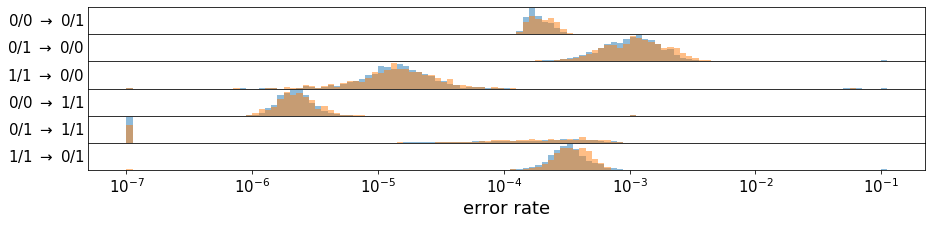

In [85]:
fig = plt.figure(figsize=(15, 3))
fig.suptitle('', fontsize=18)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#009668', '#ce93d8', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
for i, (g, o) in enumerate(errors_of_interest):
    plt.subplot(len(errors_of_interest), 1, i+1)
    plt.hist(-np.clip(ihart_error_rates[ihart_samples.is_child & is_male, gens.index(g), obss.index(o)], 1, 7), 
                bins=np.arange(-7, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), density=True, alpha=0.5)
    plt.hist(-np.clip(ihart_error_rates[ihart_samples.is_child & is_female, gens.index(g), obss.index(o)], 1, 7), 
                bins=np.arange(-7, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), density=True, alpha=0.5)

    plt.yticks([], [])
    if i == len(errors_of_interest)-1:
        plt.xlabel('error rate', fontsize=18)
        plt.xticks(np.arange(-7, 0), ['$10^{%d}$' % d for d in np.arange(-7, 0)], fontsize=15)
    else:
        plt.xticks([], [])

    #plt.subplot(len(errors_of_interest), 2, 2*i+2)
    #plt.hist(np.clip(np.log10(ihart_error_counts[ihart_samples.is_child, gens.index(g), obss.index(o)]), 0, 5), 
    #            bins=np.arange(0, 5.2, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), color=colors[i], density=True)

    plt.yticks([], [])
    plt.ylabel(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=15)

    #if i == len(errors_of_interest)-1:
    #    plt.xlabel('number of errors', fontsize=18)
    #    plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)], fontsize=15)
    #else:
    #    plt.xticks([], [])

plt.subplots_adjust(hspace=0.0, wspace=0.23)
    
plt.show()

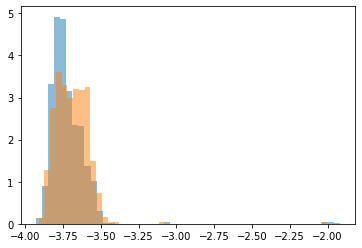

In [77]:
g = '0/0'
o = '0/1'
plt.hist(-ihart_error_rates[ihart_samples.is_child & is_male, gens.index(g), obss.index(o)], 
         alpha=0.5, bins=50, density=True)
plt.hist(-ihart_error_rates[ihart_samples.is_child & is_female, gens.index(g), obss.index(o)],
        alpha=0.5, bins=50, density=True)
plt.show()

# ethnicity

In [63]:
# pull mds
mds = np.zeros((len(ihart_samples.sample_ids), 4))
ihart_sample_id_to_index = dict([(x, i) for (i, x) in enumerate(ihart_samples.sample_ids)])
with open('../data/mds/1kg+v34+ssc+psp-mds.mds', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        sample_id = pieces[1]

        if sample_id in ihart_sample_id_to_index:
            mds[ihart_sample_id_to_index[sample_id], :] = [float(pieces[3]), float(pieces[4]), float(pieces[5]), float(pieces[6])]

print(mds)

[[-0.0269626   0.0107063  -0.00085905 -0.00316247]
 [-0.0252163   0.0159975  -0.00152869 -0.0049946 ]
 [-0.0265984   0.0142984  -0.00171368 -0.00535378]
 ...
 [-0.00833939 -0.0232899   0.0312247   0.00439868]
 [-0.0122729  -0.0189574   0.0278594   0.00485579]
 [-0.00981345 -0.0266734   0.0339484   0.00499919]]


In [75]:
from statsmodels.regression.linear_model import GLS

model = GLS(np.argsort(ihart_error_rates[ihart_samples.is_child, gens.index('1/1'), obss.index('0/1')]),
           np.hstack((np.ones((np.sum(ihart_samples.is_child), 1)), mds[ihart_samples.is_child, :])))
result = model.fit()
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.719
Date:                Sat, 08 Feb 2020   Prob (F-statistic):              0.143
Time:                        11:57:23   Log-Likelihood:                -18108.
No. Observations:                2289   AIC:                         3.623e+04
Df Residuals:                    2284   BIC:                         3.625e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1157.9155     17.928     64.587      0.0

In [97]:
spark_exome200_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'spark_exome_EX200_ind_pass_nodel_params.json', chroms, gens, obss)
spark_exome1000_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'spark_exome_EX1000_ind_pass_nodel_params.json', chroms, gens, obss)



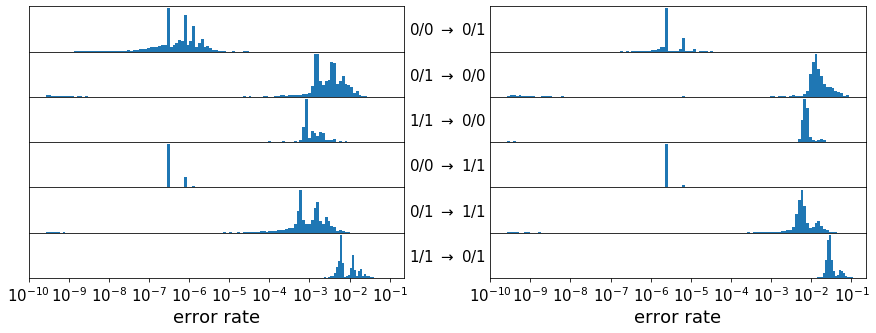

In [102]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('', fontsize=18)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#009668', '#ce93d8', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
for i, (g, o) in enumerate(errors_of_interest):
    plt.subplot(len(errors_of_interest), 2, 2*i+1)
    plt.hist(-np.clip(spark_exome200_error_rates[spark_exome_samples.is_child, gens.index(g), obss.index(o)], 1, 10), 
                bins=np.arange(-7, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), density=True)
    plt.yticks([], [])
    if i == len(errors_of_interest)-1:
        plt.xlabel('error rate', fontsize=18)
        plt.xticks(np.arange(-10, 0), ['$10^{%d}$' % d for d in np.arange(-10, 0)], fontsize=15)
    else:
        plt.xticks([], [])

    plt.subplot(len(errors_of_interest), 2, 2*i+2)
    plt.hist(-np.clip(spark_exome1000_error_rates[spark_exome_samples.is_child, gens.index(g), obss.index(o)], 1, 10), 
                bins=np.arange(-7, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), density=True)
    plt.yticks([], [])
    if i == len(errors_of_interest)-1:
        plt.xlabel('error rate', fontsize=18)
        plt.xticks(np.arange(-10, 0), ['$10^{%d}$' % d for d in np.arange(-10, 0)], fontsize=15)
    else:
        plt.xticks([], [])

    plt.yticks([], [])
    plt.ylabel(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=15)

    
plt.subplots_adjust(hspace=0.0, wspace=0.23)
    
plt.show()